In [1]:
device = "TPU-VM" #or "GPU"

In [2]:
if device=='TPU-VM':
    !pip install -q seaborn
#     !pip install -q sklearn
#     !pip install -q scikit-learn --upgrade
#     !pip install -q mlxtend
    
    
    # # FOR TPU VM
#     !pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
#     !pip install -q tensorflow-addons==0.18.0
#     !pip install -q tensorflow-probability==0.17.0
#     !pip install -q opencv-python-headless
#     !pip install -q seaborn
    
    # Custom Libraries
    # !pip install -q keras-cv-attention-models
    # !pip install -qU wandb
    # !pip install -qU scikit-learn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# import Deep learning Libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_effnet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import preprocess_input 

from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')
print('Running TF: ', tf.__version__)

D0702 17:39:11.622221192      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0702 17:39:11.622247652      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0702 17:39:11.622251312      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0702 17:39:11.622254227      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0702 17:39:11.622257004      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0702 17:39:11.622259923      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0702 17:39:11.622263825      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0702 17:39:11.

modules loaded
Running TF:  2.12.0


In [4]:
!pip install -q efficientnet
!pip install -q image-classifiers

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [5]:
import efficientnet.tfkeras as efn
from classification_models.keras import Classifiers
seresnext101, preprocess_senet = Classifiers.get('seresnext101')

In [6]:
if "TPU" in device:
    tpu = 'local' if device=='TPU-VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        device = "GPU"
        
if device == "GPU"  or device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        device = "CPU"

if device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

# Data Loading

In [7]:
def augment(img, label):
    # Random horizontal flip
    img = tf.image.random_flip_left_right(img)
    
    # Random rotation
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    img = tf.cond(choice < 0.5, lambda: img, lambda: random_crop(img))
    
    return img, label

In [8]:
import random

def decode_image(filename, label, image_size=(224, 224)):
    img = tf.io.read_file(filename)
    img = tf.image.decode_bmp(img, channels=3)
    img = tf.image.resize(img, image_size, method='bicubic')
    img = tf.cast(img, tf.float32)
    img = tf.reshape(img, [224, 224, 3]) 
    return img, label

def load_ds(data_folder, shuffle=False):
    # Get the list of all the images
    classes = ['hem', 'all']  # Replace with your classes
    files_labels = []
    for i, cls in enumerate(classes):
        files = tf.io.gfile.glob(str(data_folder) + cls + '/*.bmp')
        labels = [i]*len(files)  # Create labels
        files_labels += list(zip(files, labels))
        print(len(files), len(labels), data_folder, cls)

    # Shuffle files and labels together if required
    if shuffle:
        random.shuffle(files_labels)

    filenames = [item[0] for item in files_labels]
    labels = [item[1] for item in files_labels]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

def get_datasets(train_folder, valid_folder, test_folder):
    train_ds = load_ds(train_folder)
    valid_ds = load_ds(valid_folder, shuffle=True)  # Shuffle validation data once
    test_ds = load_ds(test_folder)
    
    # Shuffle the training data
    BUFFER_SIZE = 30000  # use a buffer size the same as or larger than the full dataset size for full shuffling
    train_ds = train_ds.shuffle(BUFFER_SIZE)
    
    # Apply augmentation only to the training data
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # You can add batch, prefetch, and shuffle here as needed
    train_ds = train_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
    valid_ds = valid_ds.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.batch(64, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_ds, valid_ds, test_ds  


In [9]:
# Load datasets
train_ds, valid_ds, test_ds = get_datasets('/kaggle/input/leuk-isbi-zero/train/', '/kaggle/input/leuk-augs-zero/val/', '/kaggle/input/leuk-augs-zero/test/')

2372 2372 /kaggle/input/leuk-isbi-zero/train/ hem
5090 5090 /kaggle/input/leuk-isbi-zero/train/ all
508 508 /kaggle/input/leuk-augs-zero/val/ hem
1090 1090 /kaggle/input/leuk-augs-zero/val/ all
509 509 /kaggle/input/leuk-augs-zero/test/ hem
1092 1092 /kaggle/input/leuk-augs-zero/test/ all


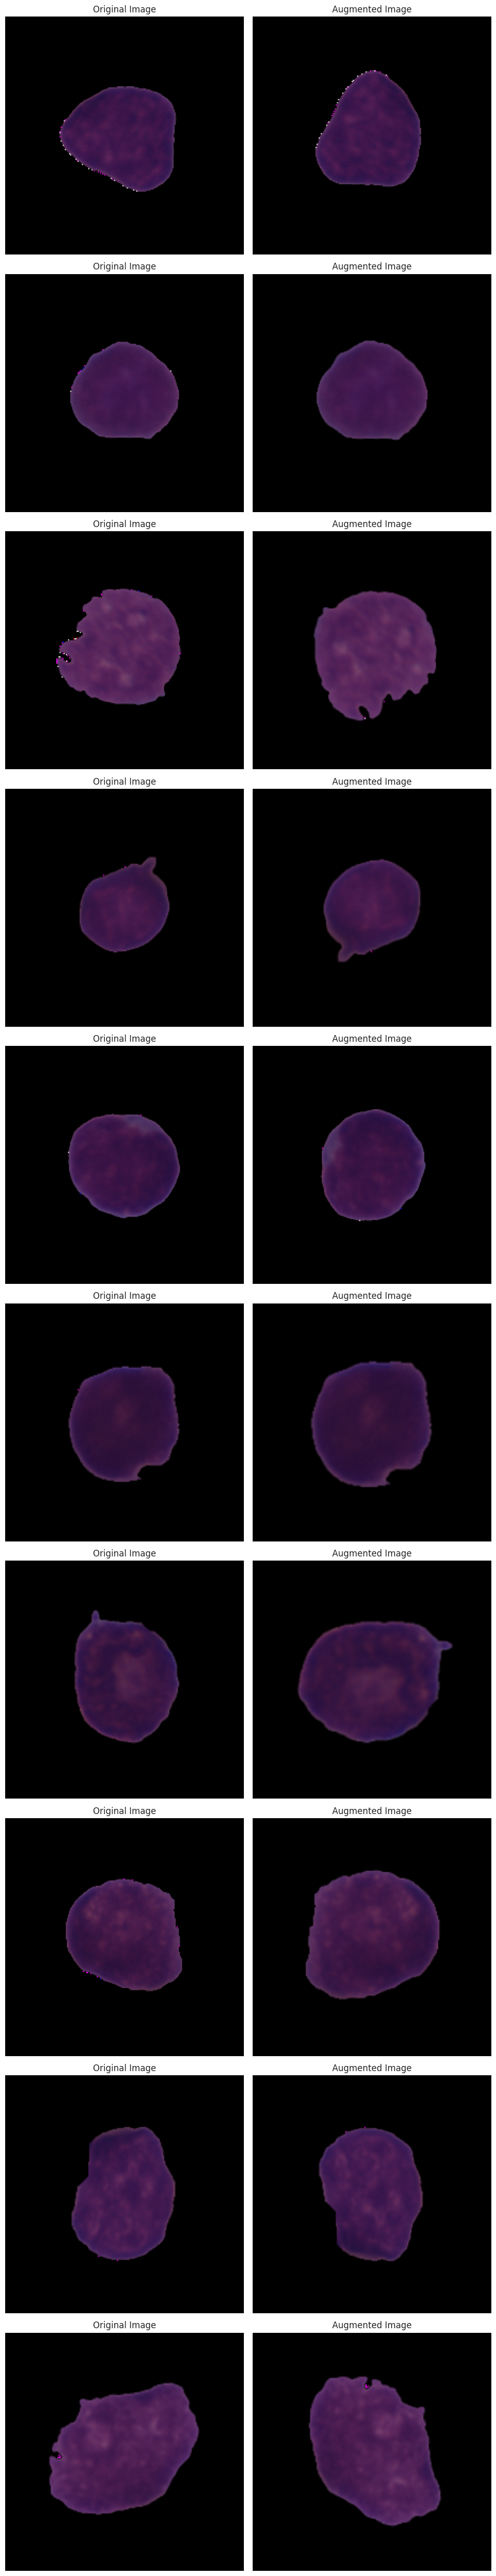

In [10]:
def visualize_augmentations(dataset, n_images):
    # Unbatch the dataset
    dataset = dataset.unbatch().batch(n_images)

    for images, labels in dataset.take(1):
        # Apply the augmentations
        augmented_images = [augment(image, label)[0] for image, label in zip(images, labels)]

        # Plot the original and augmented images side by side
        fig, axes = plt.subplots(n_images, 2, figsize=(10, n_images * 5))

        for i, image in enumerate(images):
            axes[i, 0].imshow(image.numpy().astype("uint8"))
            axes[i, 0].axis('off')
            axes[i, 0].set_title('Original Image')

            axes[i, 1].imshow(augmented_images[i].numpy().astype("uint8"))
            axes[i, 1].axis('off')
            axes[i, 1].set_title('Augmented Image')
            
        plt.tight_layout()
        plt.show()
        break

visualize_augmentations(train_ds, 10)

# Model Building

In [13]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as prepro_func
import tensorflow_addons as tfa

In [14]:
def Ranger():
    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    return ranger

In [15]:
with strategy.scope():

    base_model = tf.keras.applications.convnext.ConvNeXtBase(include_top= False, weights= "imagenet", input_shape= (224, 224, 3), pooling= 'max')
    
    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.35, seed= 123),
        Dense(1, activation= 'sigmoid')
    ])

    model.build(input_shape=(None, 224, 224, 3))
    model.compile(optimizer=Ranger(), loss=tf.keras.losses.BinaryCrossentropy(), metrics= [tf.keras.metrics.BinaryAccuracy()])

model.summary()

350926856/350926856 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 87,833,217
Trainable params: 87,831,169
N

In [16]:
# callbacks

# ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_weights.h5", 
                                save_best_only=True, 
                                save_weights_only=True,
                                monitor='val_loss', 
                                mode='min')

# CSVLogger callback
csv_logger = tf.keras.callbacks.CSVLogger('training_log.csv')

learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
# earlystop=EarlyStopping(patience=3) 

callback=[learning_rate_reduction, checkpoint, csv_logger]

In [17]:
history = model.fit(train_ds,
          validation_data=valid_ds,
          epochs=150,
          callbacks=callback,
#           steps_per_epoch = train_ds.shape[0]//batch_Size,
#           validation_steps = valid_ds.shape[0]//batch_Size,
         )

Epoch 1/150


2023-07-02 17:42:17.980552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-02 17:42:21.248709: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


117/117 [==============================] - ETA: 0s - loss: 7.3914 - binary_accuracy: 0.7062

2023-07-02 17:48:30.323341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-02 17:48:30.720041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


117/117 [==============================] - 497s 2s/step - loss: 7.3914 - binary_accuracy: 0.7062 - val_loss: 6.5898 - val_binary_accuracy: 0.7741 - lr: 0.0010
Epoch 2/150
117/117 [==============================] - 24s 196ms/step - loss: 5.4239 - binary_accuracy: 0.8187 - val_loss: 4.9465 - val_binary_accuracy: 0.8548 - lr: 0.0010
Epoch 3/150
117/117 [==============================] - 24s 191ms/step - loss: 3.7709 - binary_accuracy: 0.8621 - val_loss: 4.3076 - val_binary_accuracy: 0.3179 - lr: 0.0010
Epoch 4/150
117/117 [==============================] - 23s 192ms/step - loss: 2.4498 - binary_accuracy: 0.8870 - val_loss: 2.3070 - val_binary_accuracy: 0.6777 - lr: 0.0010
Epoch 5/150
117/117 [==============================] - 24s 191ms/step - loss: 1.5242 - binary_accuracy: 0.9038 - val_loss: 1.3363 - val_binary_accuracy: 0.8811 - lr: 0.0010
Epoch 6/150
117/117 [==============================] - 24s 194ms/step - loss: 0.9542 - binary_accuracy: 0.9158 - val_loss: 0.8299 - val_binary_accura

# Results & Plots

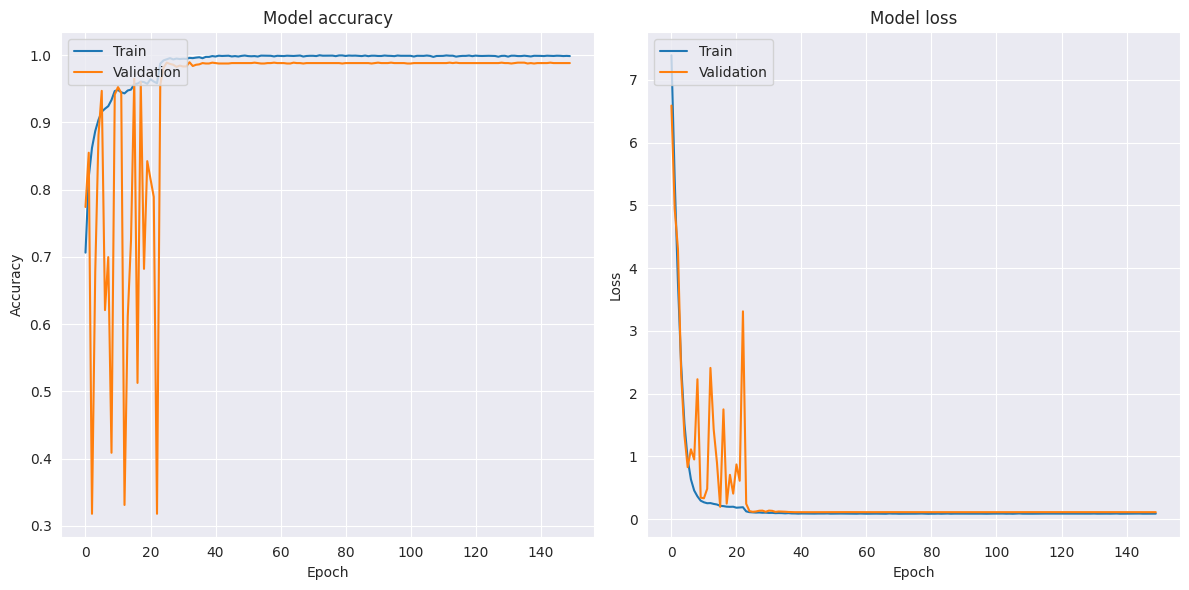

In [19]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
plot_history(history)

In [21]:
model.load_weights('best_model_weights.h5')

2023-07-02 18:45:53.435144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-02 18:45:53.654610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


25/25 [==============================] - 15s 33ms/step


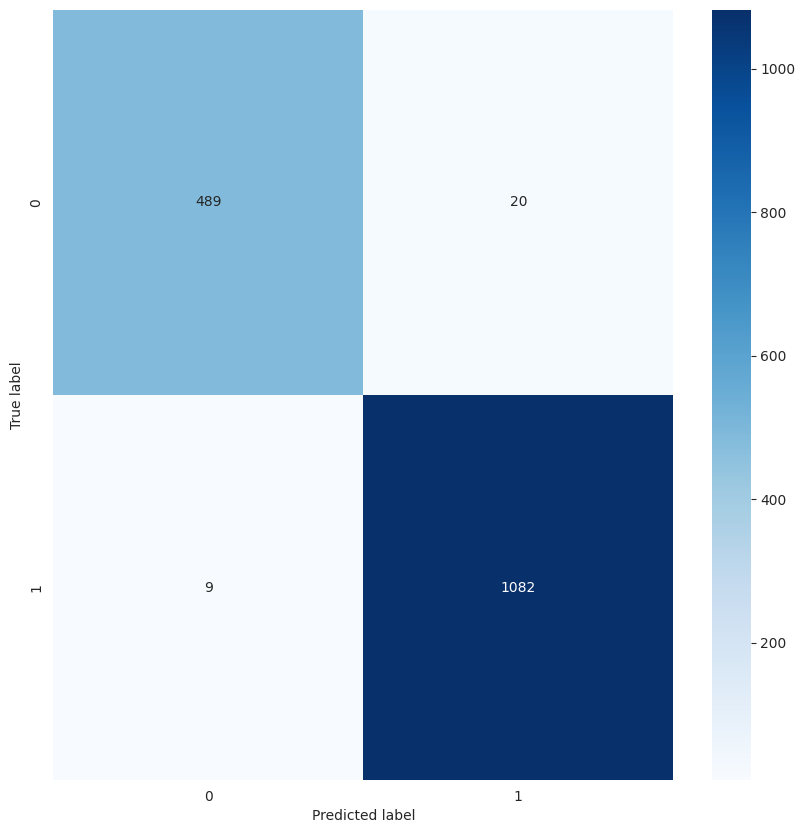

Accuracy: 98.1875%
              precision    recall  f1-score   support

         hem       0.98      0.96      0.97       509
         all       0.98      0.99      0.99      1091

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [22]:
# Generate predictions
preds = model.predict(test_ds)

# Convert predictions to labels
pred_labels = (preds > 0.5).astype(np.int)

# Extract actual labels
actual_labels = tf.concat([y for x, y in test_ds], axis=0).numpy()

classes = ['hem', 'all']  # Replace with your classes

# Print confusion matrix
cm = confusion_matrix(actual_labels, pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print accuracy
accuracy = accuracy_score(actual_labels, pred_labels)
print(f'Accuracy: {accuracy*100}%')

# Print classification report
report = classification_report(actual_labels, pred_labels, target_names=classes)
print(report)